In [1]:
# System
import gc
import os
import sys
from pathlib import Path

# Cpu
from collections import Counter
import numpy as np
import pandas as pd

# Data viz
from IPython.display import Image, display, HTML
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pprint
import seaborn as sns

plt.rcParams['legend.framealpha'] = 1
plt.rcParams['legend.frameon'] = True
plt.rcParams['legend.edgecolor'] = 'k'
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.facecolor'] = 'w'
plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125
plt.rcParams['figure.figsize'] = (16, 9)

    
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
from contextlib import contextmanager
import time
@contextmanager
def timer(name, unit='s'):
    start = time.time()
    yield
    delta = time.time() - start
    if unit == 's':
        pass
    elif unit == 'min':
        delta /= 60
    else:
        raise NotImplementedError
    print('{}: {:.2f}{}'.format(name, delta, unit))

# Clustering manuscripts through illuminations

In [3]:
PROJECT_DIR = ""

In [4]:
p = Path(PROJECT_DIR) / 'raw_data'
manuscripts = sorted(list(filter(lambda p: p.is_dir(), p.glob('*'))))

## 1. Example

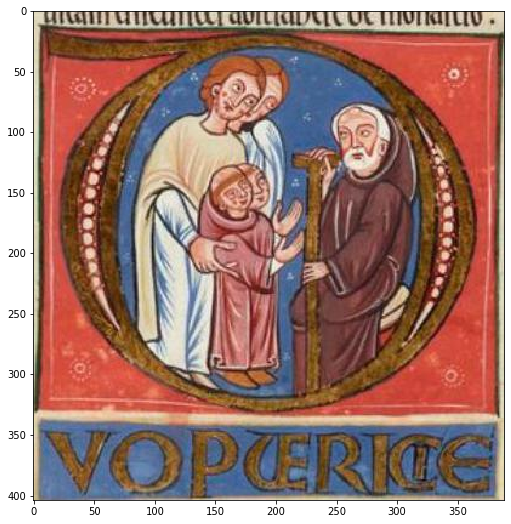

In [5]:
from cv2 import cvtColor, COLOR_RGB2Lab, COLOR_Lab2RGB
from collections import Counter

manuscript = manuscripts[-1]
illuminations = sorted(manuscript.glob('**/*.jpg'))
df = pd.DataFrame(columns=['a', 'b'])
illu = illuminations[0]
i = Image.open(illu)
arr = np.array(i)
ab = np.reshape(cvtColor(arr, COLOR_RGB2Lab)[:,:,1:], (-1, 2)).tolist()
df = pd.concat([df, pd.DataFrame(ab, columns=['a', 'b'])], ignore_index=True)
df['ab'] = list(map(tuple, df.values.tolist()))

plt.imshow(i)

In [6]:
counts = df['ab'].value_counts()
keys, values = counts.index.tolist(), counts.values
abc = np.hstack([np.array(keys), np.reshape(np.array(values), (-1, 1))])

### 1.1. Triangulation surface from pixel_count

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

colors = cvtColor(np.reshape(np.hstack([[[100]]*len(keys), np.array(keys)]), (1, -1, 3)).astype('uint8'), COLOR_Lab2RGB)[0] / 255.
x, y, z = abc[:, 0], abc[:, 1], abc[:, 2]

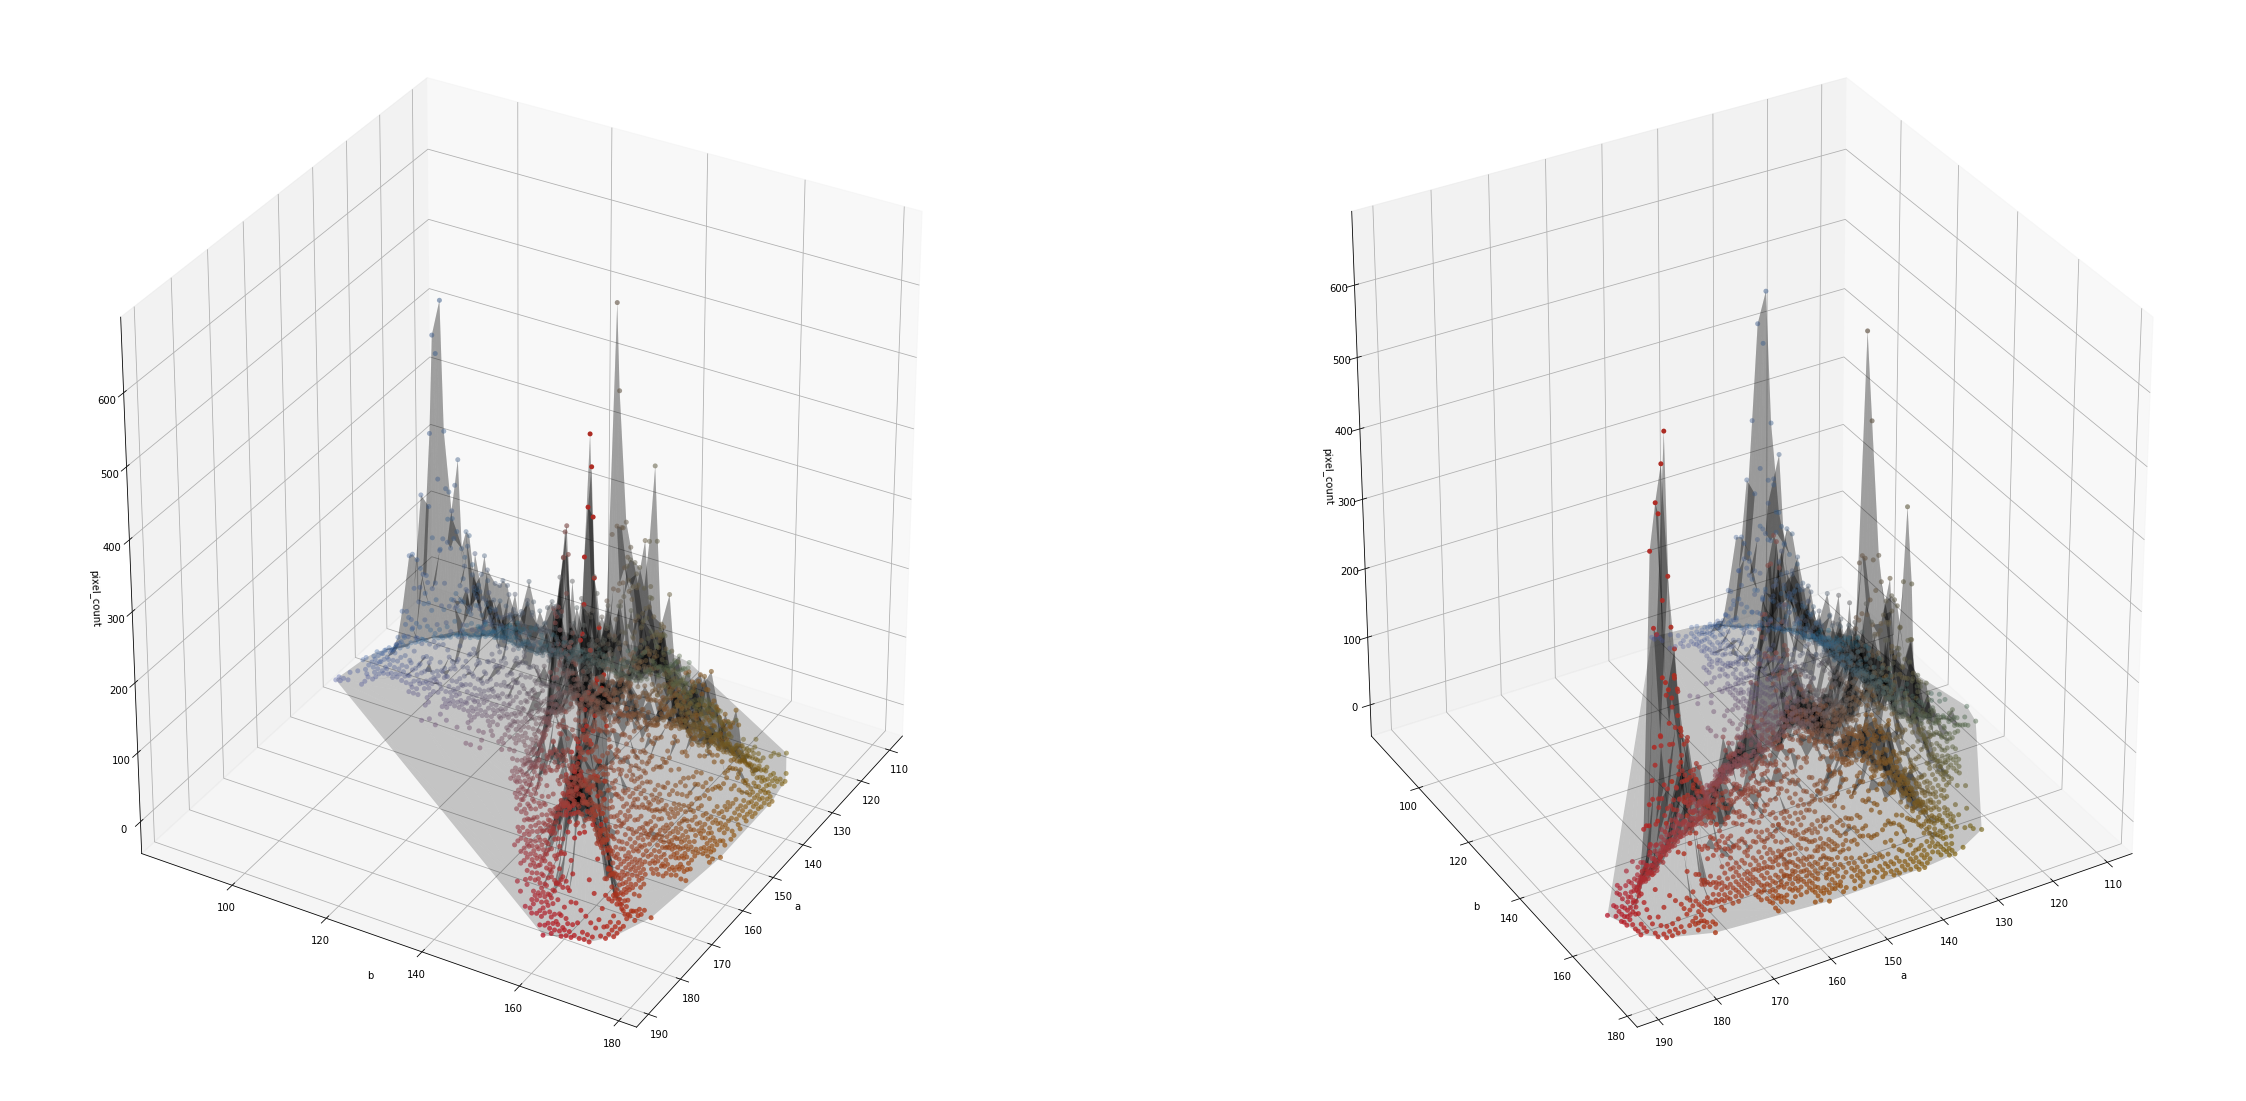

In [8]:
fig = plt.figure(figsize=(40, 20))
ax = fig.add_subplot(121, projection='3d')
ax.plot_trisurf(x, y, z, color=(0, 0, 0, 0.2), lw=1)
ax.scatter(xs=x, ys=y, zs=z, s=25,  c=colors, lw=0)
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('pixel_count')
ax.view_init(30, 30)

ax = fig.add_subplot(122, projection='3d')
ax.plot_trisurf(x, y, z, color=(0, 0, 0, 0.2), lw=1)
ax.scatter(xs=x, ys=y, zs=z, s=25,  c=colors, lw=0)
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('pixel_count')
ax.view_init(30, 60)

### 1.2. Gaussian kde

In [9]:
from scipy.stats import gaussian_kde

kernel = gaussian_kde(dataset=np.swapaxes(np.asarray(keys), 0, 1), bw_method=0.1, weights=values)
xmin, xmax = df['a'].min(), df['a'].max()
ymin, ymax = df['b'].min(), df['b'].max()
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kernel(positions).T, X.shape)
colors = cvtColor(np.dstack([np.ones(X.shape, dtype=np.uint8)*100, X, Y]).astype(np.uint8), COLOR_Lab2RGB) / 255.

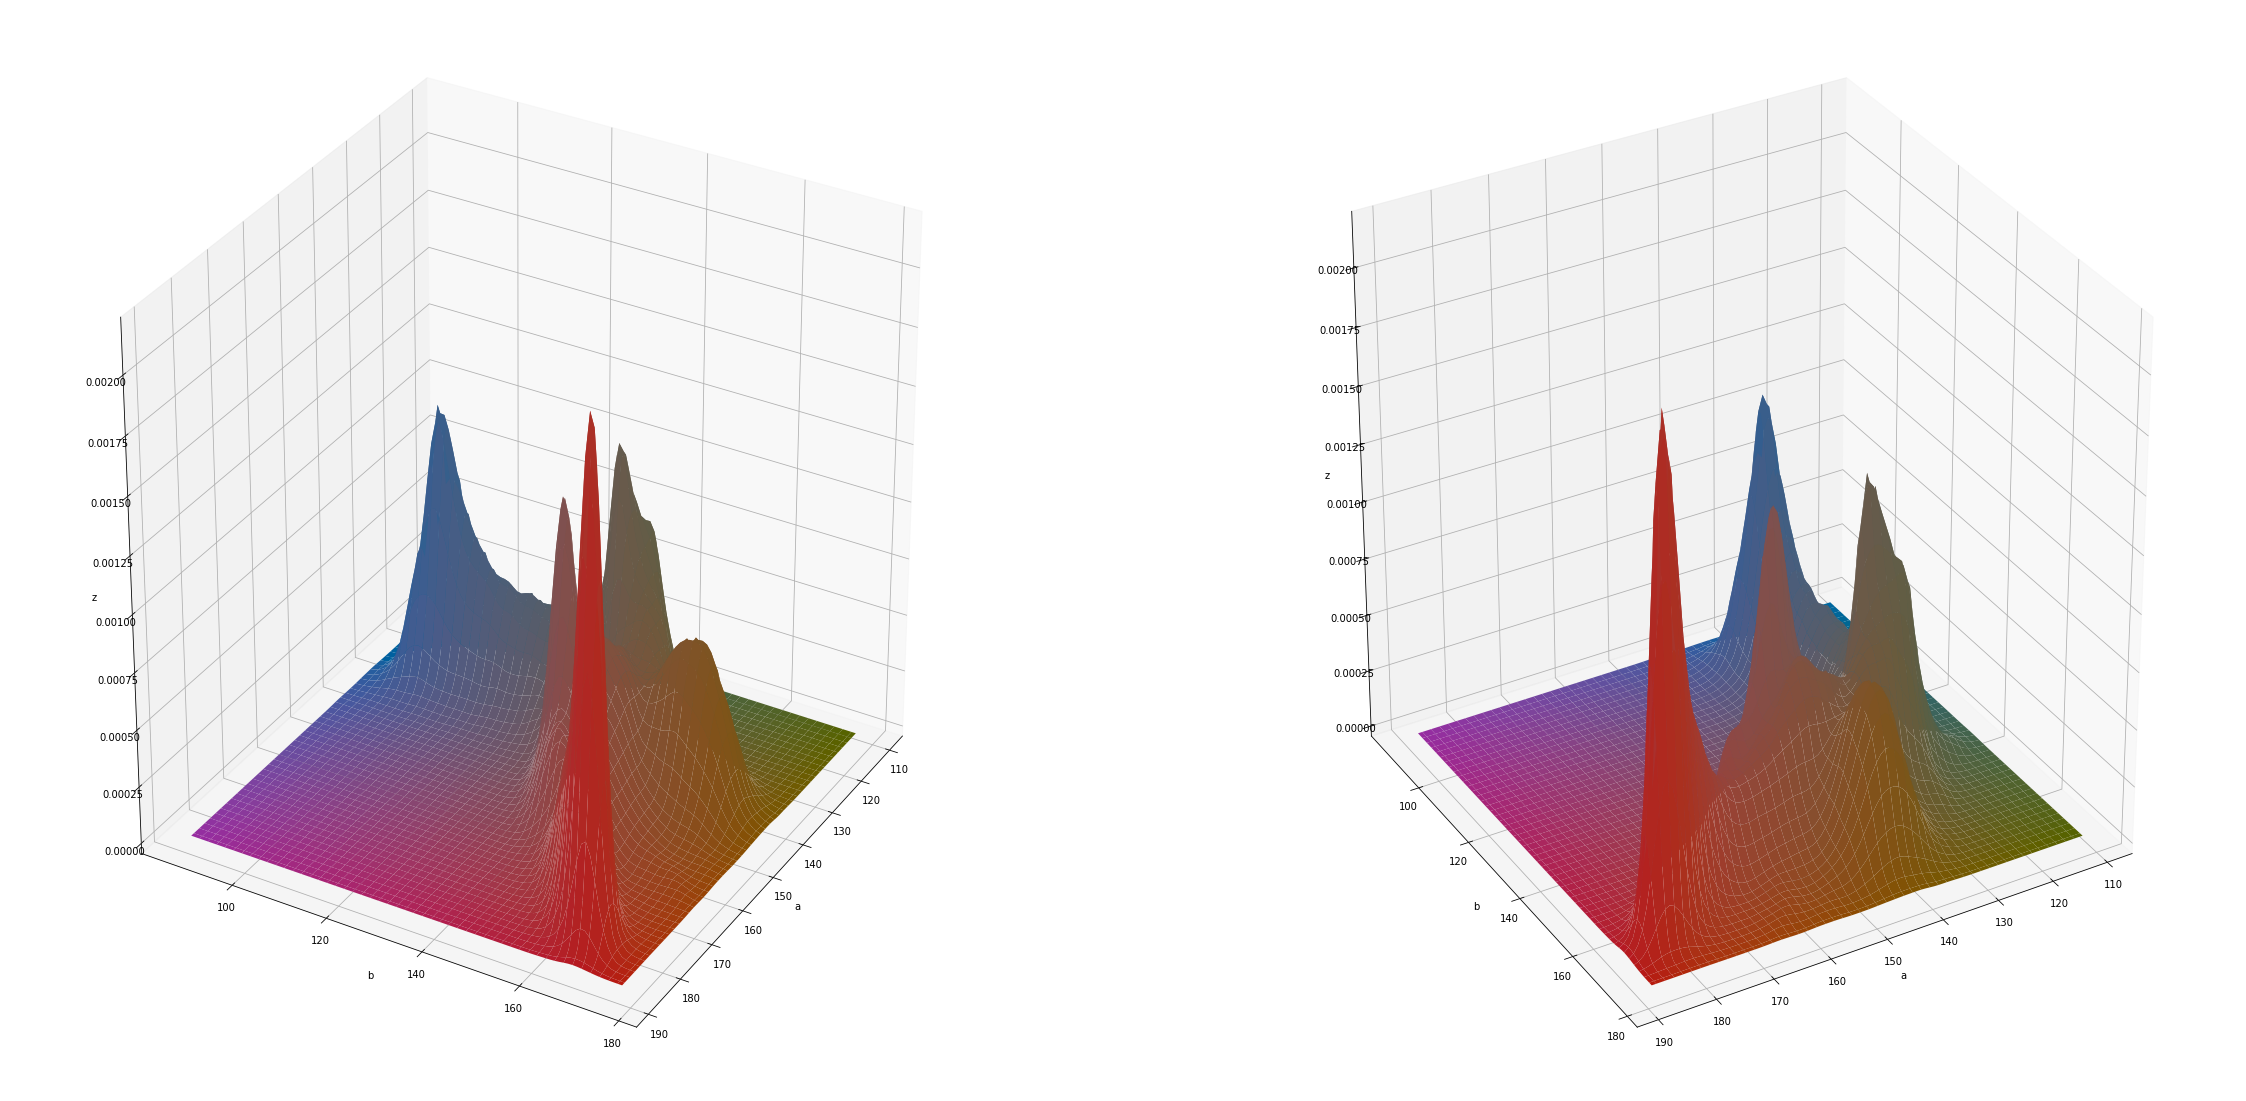

In [10]:
fig = plt.figure(figsize=(40, 20))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(X, Y, Z, rcount=50, ccount=50, facecolors=colors, shade=False, alpha=1, edgecolors='none', lw=0)
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('z')
ax.view_init(30, 30)

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, Z, rcount=50, ccount=50, facecolors=colors, shade=False, alpha=1, edgecolors='none', lw=0)
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('z')
ax.view_init(30, 60)

### 1.3. Mean Shift clustering

In [14]:
from sklearn.cluster import MeanShift

sample = df.sample(10000)
cluster = MeanShift(bandwidth=10, n_jobs=-1).fit(sample[['a', 'b']])
unique_labels = np.unique(cluster.labels_)
len(unique_labels)

7

#### Visualisation in pixel_count space

In [15]:
counts = df['ab'].value_counts()
keys, values = counts.index.tolist(), counts.values
abc = np.hstack([np.array(keys), np.reshape(np.array(values), (-1, 1))])
x, y, z = abc[:, 0], abc[:, 1], abc[:, 2]

from matplotlib.cm import get_cmap
from matplotlib.colors import ListedColormap

colors_list = cvtColor(np.reshape(np.hstack([[[100]]*len(unique_labels), cluster.cluster_centers_]), (1, -1, 3)).astype('uint8'), COLOR_Lab2RGB)[0] / 255.
cmap = ListedColormap(colors_list)
colors = cmap(cluster.predict(keys))

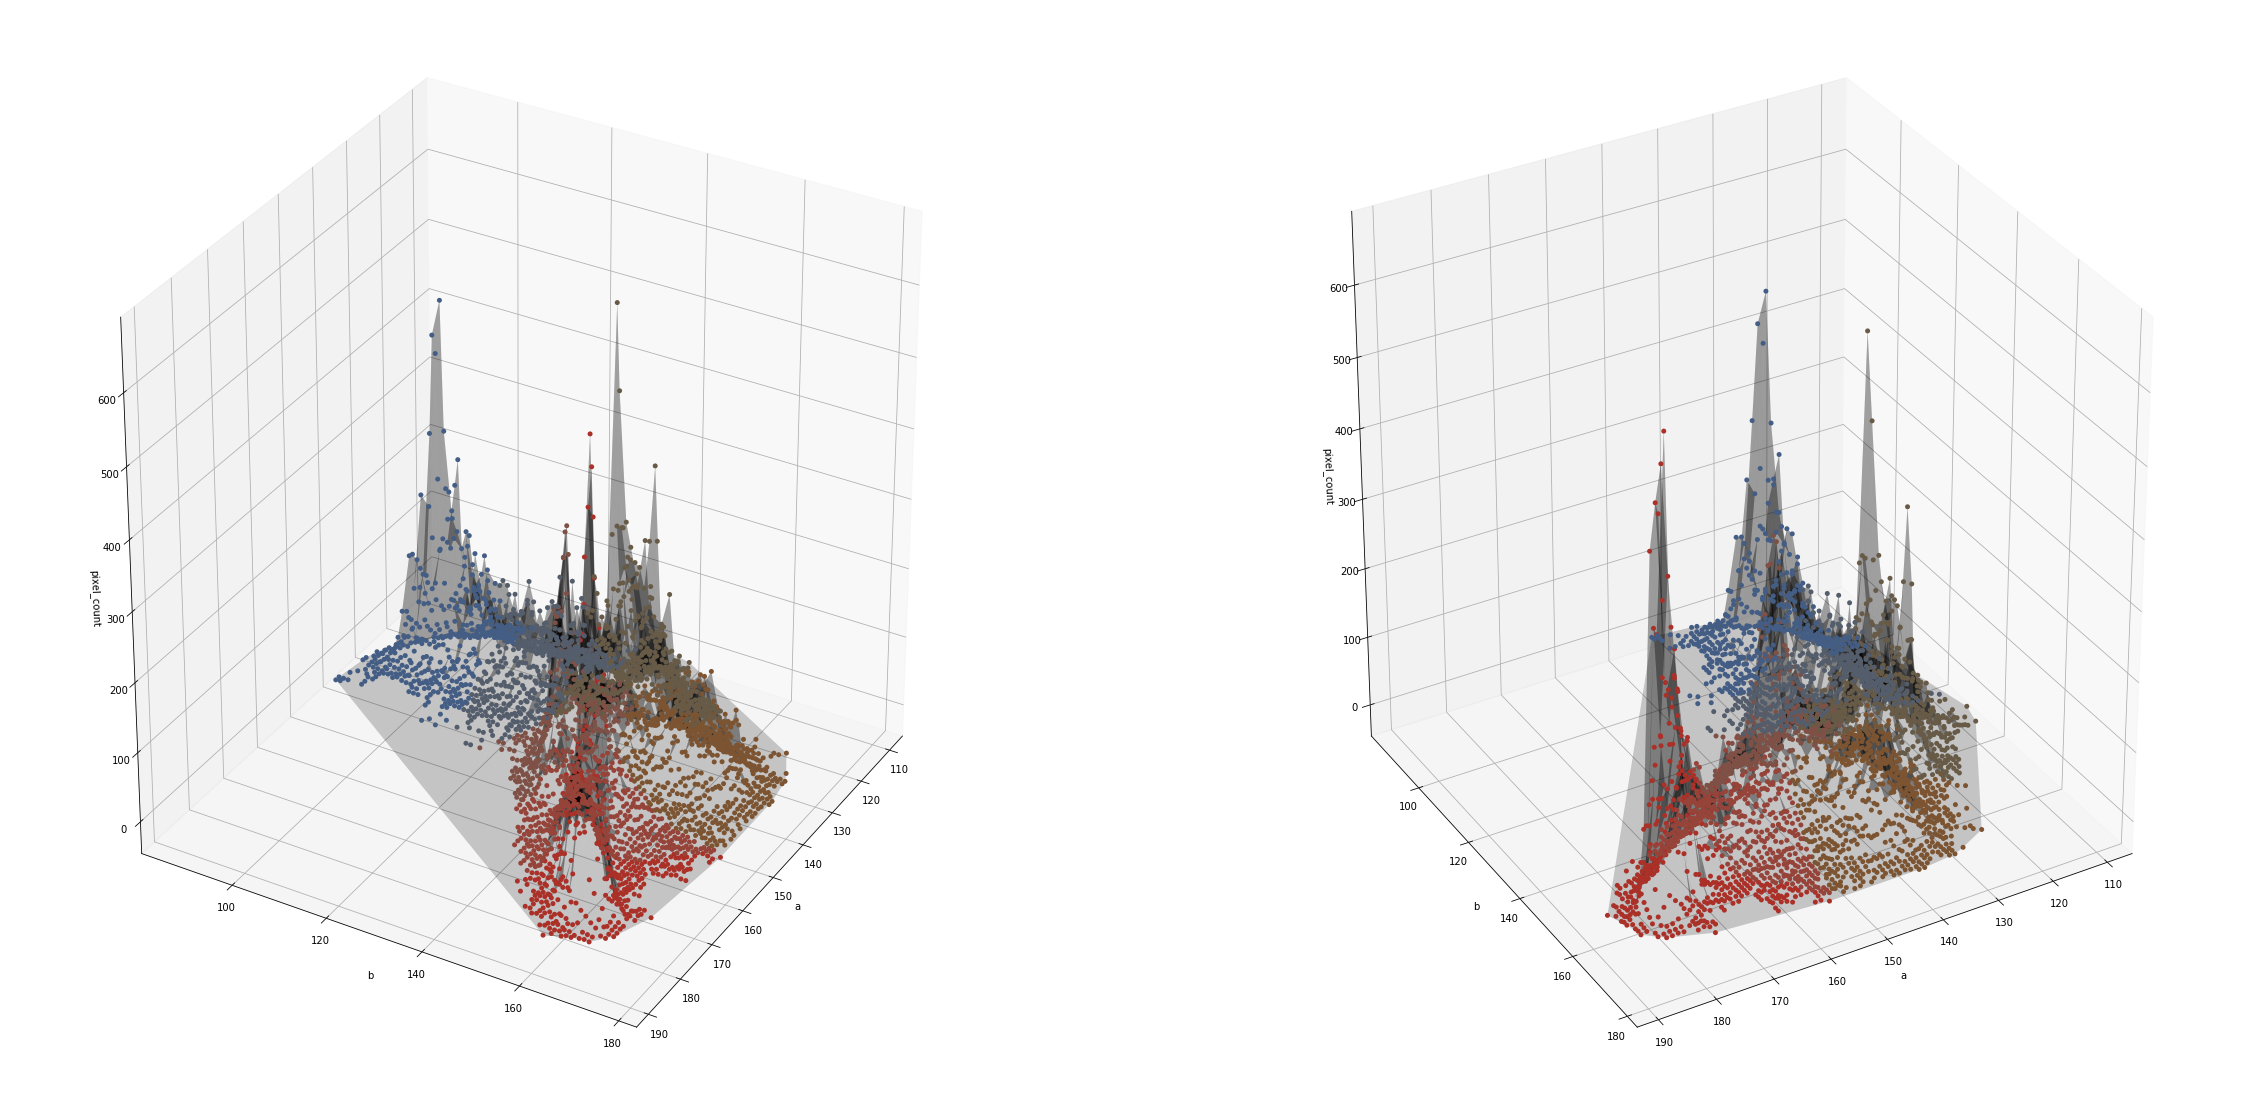

In [16]:
fig = plt.figure(figsize=(40, 20))
ax = fig.add_subplot(121, projection='3d')
ax.plot_trisurf(x, y, z, color=(0, 0, 0, 0.2), lw=1)
ax.scatter(xs=x, ys=y, zs=z, s=25,  c=colors, lw=0, depthshade=False)
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('pixel_count')
ax.view_init(30, 30)

ax = fig.add_subplot(122, projection='3d')
ax.plot_trisurf(x, y, z, color=(0, 0, 0, 0.2), lw=1)
ax.scatter(xs=x, ys=y, zs=z, s=25,  c=colors, lw=0, depthshade=False)
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('pixel_count')
ax.view_init(30, 60)

#### Visualisation in original image space

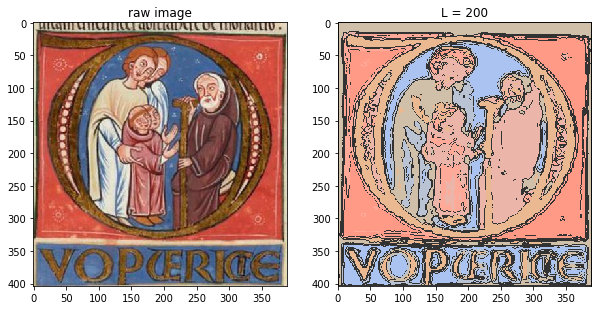

In [20]:
import cv2
l = 200
colors_list = cvtColor(np.reshape(np.hstack([[[l]]*len(unique_labels), cluster.cluster_centers_]), (1, -1, 3)).astype('uint8'), COLOR_Lab2RGB)[0] / 255.
cmap = ListedColormap(colors_list)
labels = cluster.predict(df[['a', 'b']]).reshape(arr.shape[:2])
colors = cmap(labels)[:, :, :3] * 255
res_img = colors.astype(np.uint8)
contours = []
for k in unique_labels:
    mask = (labels == k).astype(np.uint8)
    contour, _ = cv2.findContours(mask,  cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours += contour
cv2.drawContours(res_img, contours, -1, (50, 50, 50), thickness=1)

fig, ax = plt.subplots(1, 2, figsize=(5*2, 5))
ax[0].imshow(i)
ax[0].set_title('raw image')
ax[1].imshow(Image.fromarray(res_img))
_ = ax[1].set_title('L = 200')